# Unconditional Diffusion Generation Examples
This notebook shows how diffusion models can be used to generate realistic-looking synthetic imagery. The general workflow holds true for most other diffusion-based tasks such as super-resolution, conditional or text-based generation, and inpainting. The tutorial is inspired by [this repository](https://github.com/mikonvergence/DiffusionFastForward)


## 0. Handle Imports and Data

In [1]:
!git clone https://github.com/mikonvergence/DiffusionFastForward
!pip install pytorch-lightning==1.9.3 diffusers einops kornia

Cloning into 'DiffusionFastForward'...
remote: Enumerating objects: 154, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 154 (delta 62), reused 50 (delta 50), pack-reused 85 (from 1)
Receiving objects: 100% (154/154), 4.19 MiB | 4.39 MiB/s, done.
Resolving deltas: 100% (85/85), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.4/826.4 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 833.3/833.3 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 25.3 MB/s eta 0:00:00


In [2]:
!cp /content/drive/MyDrive/valencia_share/diffusion_confusion/data/butterflies.zip butterflies.zip

In [3]:
!unzip -o -q butterflies.zip

In [4]:
!mkdir example_images
!mkdir checkpoints

In [37]:
import sys
sys.path.append('./DiffusionFastForward/')

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from PIL import Image
from IPython.display import display
from tqdm import tqdm


import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import imageio
from skimage import io
import os

from src import *

mpl.rcParams['figure.figsize'] = (8, 8)

# 1.1 Data Functions

In [78]:
# Define the Dataset
class ImageFolderDataset(Dataset):
    def __init__(self, folder_path,target_size=64):
        self.folder_path,self.target_size = folder_path,target_size
        self.image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = T.ToTensor()
        #self.image_files = self.image_files[:100]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        image = image.resize((self.target_size,self.target_size), Image.BILINEAR)
        image = self.transform(image)
        return image

class ValDataset(Dataset):
    def __init__(self):
      pass
    def __len__(self):
      return(1)
    def __getitem__(self,idx):
      return {}


# Create the dataset
folder_path = "/content/test"
dataset_train = ImageFolderDataset(folder_path)
dataset_val = ValDataset()
sample_batch = dataset_train.__getitem__(100).unsqueeze(0)

print(f"Dataset Instanciated with {len(dataset_train)} images.")

Dataset Instanciated with 2786 images.


# 2. Investigating Functions and Components
### 2.1 Looking at data

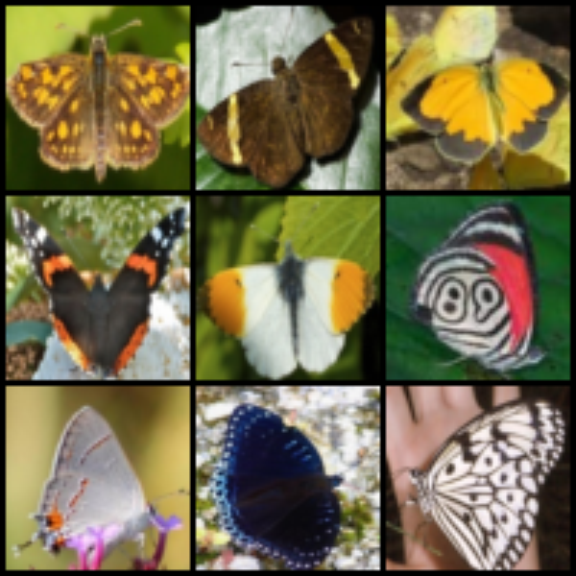

In [13]:
def plot_grid(dataset,nrow=2):
    assert nrow in [1,2,3], "nrow must be in 1,2,3. Otherwise will take too long"
    from torchvision.utils import make_grid
    from torchvision.transforms import ToPILImage

    # generate Images with DDPM
    b = nrow**2
    images = []
    for i in range(b):
        images.append(dataset.__getitem__(i))
    images = torch.stack(images)

    # Create a 3x3 grid of the generated images
    image_grid = make_grid(images, nrow=nrow)
    pil_image = ToPILImage()(image_grid)
    pil_image = pil_image.resize((nrow*64*3,nrow*64*3), Image.BILINEAR) # make image larger
    return(pil_image)

display(plot_grid(dataset_train,nrow=3))

### 2.2 Tracing Forward Step

In [ ]:
# Instanciate Model
model=PixelDiffusion(train_dataset=dataset_train,
                     valid_dataset=dataset_val,
                     num_timesteps=500,
                     lr=1e-4,
                     batch_size=24)
model = model.cuda()



```
def forward(self,
                shape=(256,256),
                batch_size=1,
                sampler=None,
                verbose=False
               ):
        """
            forward() function triggers a complete inference cycle
            
            A custom sampler can be provided as an argument!
        """           
        
        # read dimensions
        b,c,h,w=batch_size,self.generated_channels,*shape
        device=next(self.model.parameters()).device
        
        # select sampler
        if sampler is None:
            sampler=self.sampler
        else:
            sampler.to(device)

        # time steps list
        num_timesteps=sampler.num_timesteps
        it=reversed(range(0, num_timesteps))    
        
        x_t = torch.randn([b, self.generated_channels, h, w],device=device)
                
        for i in tqdm(it, desc='diffusion sampling', total=num_timesteps):
            t = torch.full((b,), i, device=device, dtype=torch.long)
            z_t=self.model(x_t,t) # prediction of noise
            x_t = sampler(x_t,t,z_t) # prediction of next state
            
        return x_t```



In [64]:
out = model.model.forward(shape=(16,16),verbose=True)
print(out.shape)

diffusion sampling:   0%|          | 0/500 [00:00<?, ?it/s]

torch.Size([1, 3, 16, 16])


In [36]:
# Conditioning Tensor
b = 1 # batches
c = 3 # Channels
h,w = 128,128
x_t = torch.randn([b, c, h, w])
print("Shape, Min, Mean, Max\n",x_t.shape,x_t.min().item(),x_t.mean(),x_t.max())

Shape, Min, Mean, Max
 torch.Size([1, 3, 128, 128]) -3.946488618850708 tensor(0.0043) tensor(3.9136)


In [30]:
print("No. of Timesteps:",model.model.num_timesteps)
print("Timesteps:\n",*reversed(range(0, model.model.num_timesteps)))

No. of Timesteps: 500
Timesteps:
 499 498 497 496 495 494 493 492 491 490 489 488 487 486 485 484 483 482 481 480 479 478 477 476 475 474 473 472 471 470 469 468 467 466 465 464 463 462 461 460 459 458 457 456 455 454 453 452 451 450 449 448 447 446 445 444 443 442 441 440 439 438 437 436 435 434 433 432 431 430 429 428 427 426 425 424 423 422 421 420 419 418 417 416 415 414 413 412 411 410 409 408 407 406 405 404 403 402 401 400 399 398 397 396 395 394 393 392 391 390 389 388 387 386 385 384 383 382 381 380 379 378 377 376 375 374 373 372 371 370 369 368 367 366 365 364 363 362 361 360 359 358 357 356 355 354 353 352 351 350 349 348 347 346 345 344 343 342 341 340 339 338 337 336 335 334 333 332 331 330 329 328 327 326 325 324 323 322 321 320 319 318 317 316 315 314 313 312 311 310 309 308 307 306 305 304 303 302 301 300 299 298 297 296 295 294 293 292 291 290 289 288 287 286 285 284 283 282 281 280 279 278 277 276 275 274 273 272 271 270 269 268 267 266 265 264 263 262 261 260 259 25

In [54]:
# Testing prediction Step
# 1. Prediction Step
x_t = torch.rand(1,3,64,64).cuda() # create conditioning
t   = torch.full((1,), 499).cuda() # create timestep info
z_t = model.model.model.forward(x_t,t) # prediction of noise

print("Timestep:",t,"\nOutput Shape:",z_t.shape)

Timestep: tensor([499], device='cuda:0') 
Output Shape: torch.Size([1, 3, 64, 64])


In [57]:
# 2. Sampler Step
x_t = model.model.sampler(x_t,t,z_t) # subtract the predicted noise (z_t) from x_t
print(x_t.shape)

torch.Size([1, 3, 64, 64])


### 2.3 Tracing Training Step



```
    def training_step(self, batch, batch_idx):   
        images=batch
        loss = self.model.p_loss(self.input_T(images))
        
        self.log('train_loss',loss)
        
        return loss
```





```
    def p_loss(self,output):
        """
            Assumes output is in [-1,+1] range
        """        
        
        b,c,h,w=output.shape
        device=output.device
        
        # loss for training
        
        # input is the optional condition
        t = torch.randint(0, self.forward_process.num_timesteps, (b,), device=device).long()
        output_noisy, noise=self.forward_process(output,t,return_noise=True)        

        # reverse pass
        noise_hat = self.model(output_noisy, t)

        # apply loss
        return self.loss_fn(noise, noise_hat)
```



In [69]:
t = torch.randint(0, model.model.forward_process.num_timesteps, (1,), ).long()
print(t)

tensor([160])


noisy tensor at t 27


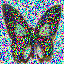

Noise


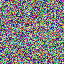

In [103]:
# Check the creation of the noisy image and target
t = torch.randint(26, 28, (1,), ).long() # Get a low T so that we can see the image
output_noisy, noise=model.model.forward_process(sample_batch.cuda(),t,return_noise=True)

# look at output
print("noisy tensor at t",t.item())
tensor = output_noisy[0].cpu().permute(1, 2, 0).numpy()
tensor = (tensor * 255).astype(np.uint8)
image = Image.fromarray(tensor)
display(image)

print("Noise")
tensor = noise[0].cpu().permute(1, 2, 0).numpy()
tensor = (tensor * 255).astype(np.uint8)
image = Image.fromarray(tensor)
display(image)

# 3. Model and Training
### 3.1 Prepare Model


In [ ]:
# define custom PL funciton to save images
def custom_on_validation_epoch_end(self,nrow = 2):
    assert nrow in [1,2,3], "nrow must be in 1,2,3. Otherwise will take too long"

    import os,torch
    from torchvision.utils import make_grid, save_image

    # generate Images with DDPM
    batch_size = nrow**2
    generated_images_tensor = self.model(batch_size=batch_size,shape=(64,64),verbose=True)

    # Create a 3x3 grid of the generated images
    image_grid = make_grid(generated_images_tensor, nrow=nrow)

    # Ensure the 'images' folder exists
    os.makedirs("images", exist_ok=True)

    # Save the grid of images as 'epoch_n.png'
    current_epoch = self.current_epoch+1
    file_path = f"example_images/epoch_{current_epoch:03}.png"
    save_image(image_grid, file_path)

    print(f"Saved generated image grid for epoch {current_epoch} at {file_path}")

def create_grid(self,nrow=2):
    assert nrow in [1,2,3], "nrow must be in 1,2,3. Otherwise will take too long"
    from torchvision.utils import make_grid
    from torchvision.transforms import ToPILImage

    # generate Images with DDPM
    b = nrow**2
    generated_images_tensor = self.model(batch_size=b,shape=(64,64),verbose=True)

    # Create a 3x3 grid of the generated images
    image_grid = make_grid(generated_images_tensor, nrow=nrow)
    pil_image = ToPILImage()(image_grid)
    pil_image = pil_image.resize((nrow*64*3,nrow*64*3), Image.BILINEAR) # make image larger
    return(pil_image)


def custom_validation_step(self, batch, batch_idx):
    pass


In [ ]:
# Model Saving Callback
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Trainer

# Define the callback
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",    # Directory to save the model checkpoints
    filename="model-{epoch}", # Filename template (epoch number will be appended)
    save_top_k=-1,             # S
    every_n_epochs=10         # Save the model after every n epoch
)

In [ ]:
# Instanciate Model
model=PixelDiffusion(train_dataset=dataset_train,
                     valid_dataset=dataset_val,
                     num_timesteps=500,
                     lr=1e-4,
                     batch_size=24)

# Set image saving funciton
model.on_validation_epoch_end = custom_on_validation_epoch_end.__get__(model)
model.validation_step = custom_validation_step.__get__(model)

# Save create Grid Function
model.create_grid = create_grid.__get__(model)
model = model.to("cuda")

# prepare PL trainer
trainer = pl.Trainer(
    max_epochs=250,
    check_val_every_n_epoch=10,
    callbacks=[EMA(0.9999),
               checkpoint_callback],
    gpus = [0]
)

Is Time embed used ?  True


/content/./DiffusionFastForward/src/EMA.py:58: UserWarning: EMA has better performance when Apex is installed: https://github.com/NVIDIA/apex#installation.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:474: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


### 3.2 Train Model

In [ ]:
trainer.fit(model)

#3. Inference

In [ ]:
for i in range(10):
  img = model.create_grid(nrow=3)
  display(img)